In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [1]:
import numpy as np
import os
from imageio import imread
from PIL import Image,ImageFilter, ImageEnhance
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# !nvidia-smi

In [17]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Gesture/Project_data/val.csv').readlines())
batch_size = 25
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120


In [18]:
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = np.array(Image.fromarray(np.uint8(image)).resize((y,z)))
#                     resized_im = imresize(image, size=(y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Gesture/Project_data/train'
val_path = '/content/gdrive/MyDrive/Gesture/Project_data/val'
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


Source path =  /content/gdrive/MyDrive/Gesture/Project_data/train ; batch size = 1


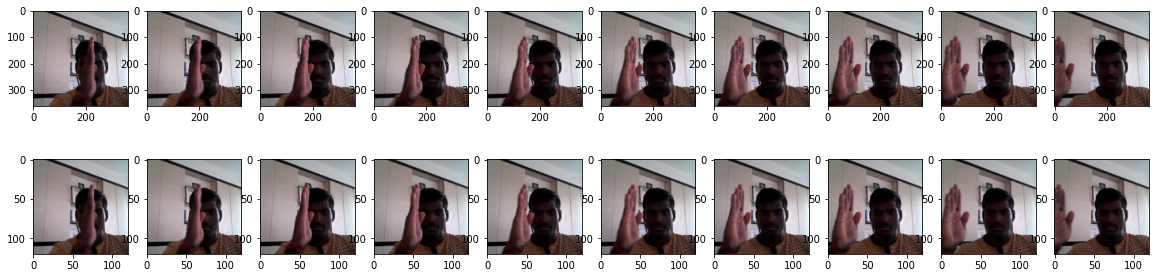

In [20]:
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

## Exp 1 : Epoch : 15, Batch Size = 32

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

## Exp 2: Epoch- 15, Batch Size: 64

In [ ]:
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

## Experiment 3: Adding more layers to the model

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

## Experiment 4: Changing batch size(32) and epoch(20)


In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

## Exp 5: Reducing learning rate to 0.0002 and batch size = 32, epoch = 15

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

In [ ]:
# optimiser = optimizers.Adam(learning_rate=0.0002) #write your optimizer
# model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# print(model.summary())

## Exp 6: Batch Normalization

In [121]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Exp 7: Adding Droput Layers with dropout=0.2 

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Exp 8: Increasing Dropout Value to 0.5

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Exp9: Increasing Batch Size:25 Epoch:20

In [ ]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Exp 10:Using Global Average Layers Epoch:40

In [22]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Experiment 11: Conv+TimeDistrbuted

In [22]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Experiment 12: Adding dropout = 0.5


In [36]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Experiment 13: Removing GRU and adding Dense layer and Global Average Pooling

In [67]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(128, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

## Experiment 14: Using Conv2DLSTM and Global Average Pooling



In [29]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [30]:
optimiser = optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization_8 (Batc  (None, 10, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_9 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [31]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [32]:
model_name = 'model_init_exp_14' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', sav=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [33]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [34]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                         validation_data=val_generator, callbacks=callbacks_list,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/Gesture/Project_data/train ; batch size = 25
Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 1.4088 - categorical_accuracy: 0.3867Source path =  /content/gdrive/MyDrive/Gesture/Project_data/val ; batch size = 25

Epoch 1: val_loss improved from inf to 1.60225, saving model to model_init_exp_14_2022-05-1816_38_48.820723/model-00001-1.40875-0.38667-1.60225-0.18000.h5
27/27 [==============================] - 37s 1s/step - loss: 1.4088 - categorical_accuracy: 0.3867 - val_loss: 1.6022 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/40
27/27 [==============================] - ETA: 0s - loss: 1.2240 - categorical_accuracy: 0.4770
Epoch 2: val_loss improved from 1.60225 to 1.59955, saving model to model_init_exp_14_2022-05-1816_38_48.820723/model-00002-1.22395-0.47704-1.59955-0.17000.h5
27/27 [==============================] - 34s 1s/step - loss: 1.2240 - categorical_accuracy: 0.4770 - val_loss: 1.5996 - val_categorical_accura

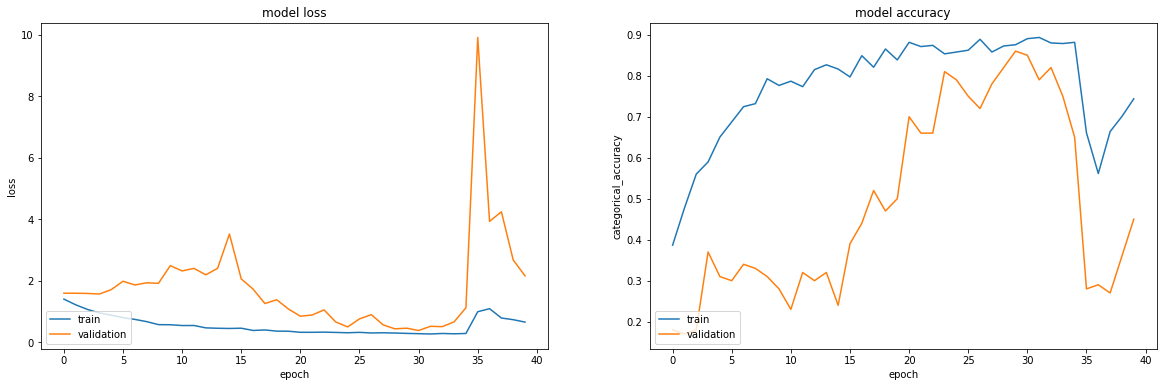

In [35]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Final Model was obtained in Experiment 14 with Training Accuracy = 0.89 and Validation Accuracy = 0.85 at epoch 31 and validation loss of just 0.38571